# Asymptotic Vocabulary

<div class="alert alert-success"> 
Asymptotic behavior of the vocabulary set size necessary to describe an emoji vs number of users
==> How many users does it take to reach a stationary phase for a given emoji?
</div>

In [64]:
%load_ext autoreload
%autoreload 2
from src.data.form10_eda import read_form, str2vocab
from src.data.asymptotic_vocab import plot_multi_trajectories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from src.data.fraudulous import *
from src.data.form10_eda import plot_emoji_time, read_meta
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
warnings.filterwarnings('ignore')
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fraud Detection, again

In [58]:
asymp_df = read_form("../data/raw/forms/Asymptotic_Emoji_Agreement_1.csv")
asymp_df.drop(columns=['👕','🚓','🇵🇱'],inplace=True)
filter_funcs = [dtct_poor_voc,
                dtct_cstt_answer,
                dtct_duplicate_answer
]
fraud_hat = find_fraudulous(asymp_df,filter_funcs)
fraud_hat

{'dtct_poor_voc': [],
 'dtct_cstt_answer': [],
 'dtct_duplicate_answer': {'AHTWZ3AZGAGSH'}}

In [59]:
asymp_df.loc['AHTWZ3AZGAGSH']

😋         good,smile,super
🤙             no,empty,not
🧓             no,empty,not
🌏      nature,green,flower
😚        feel,worry,dought
🍕         good,tree,yellow
🥊             no,empty,not
💱    sympol,maths,business
📍          rose,beauty,red
Name: AHTWZ3AZGAGSH, dtype: object

# Asymptotic Behavior Analysis

😋🤙🧓🌏😚🍕🥊💱📍

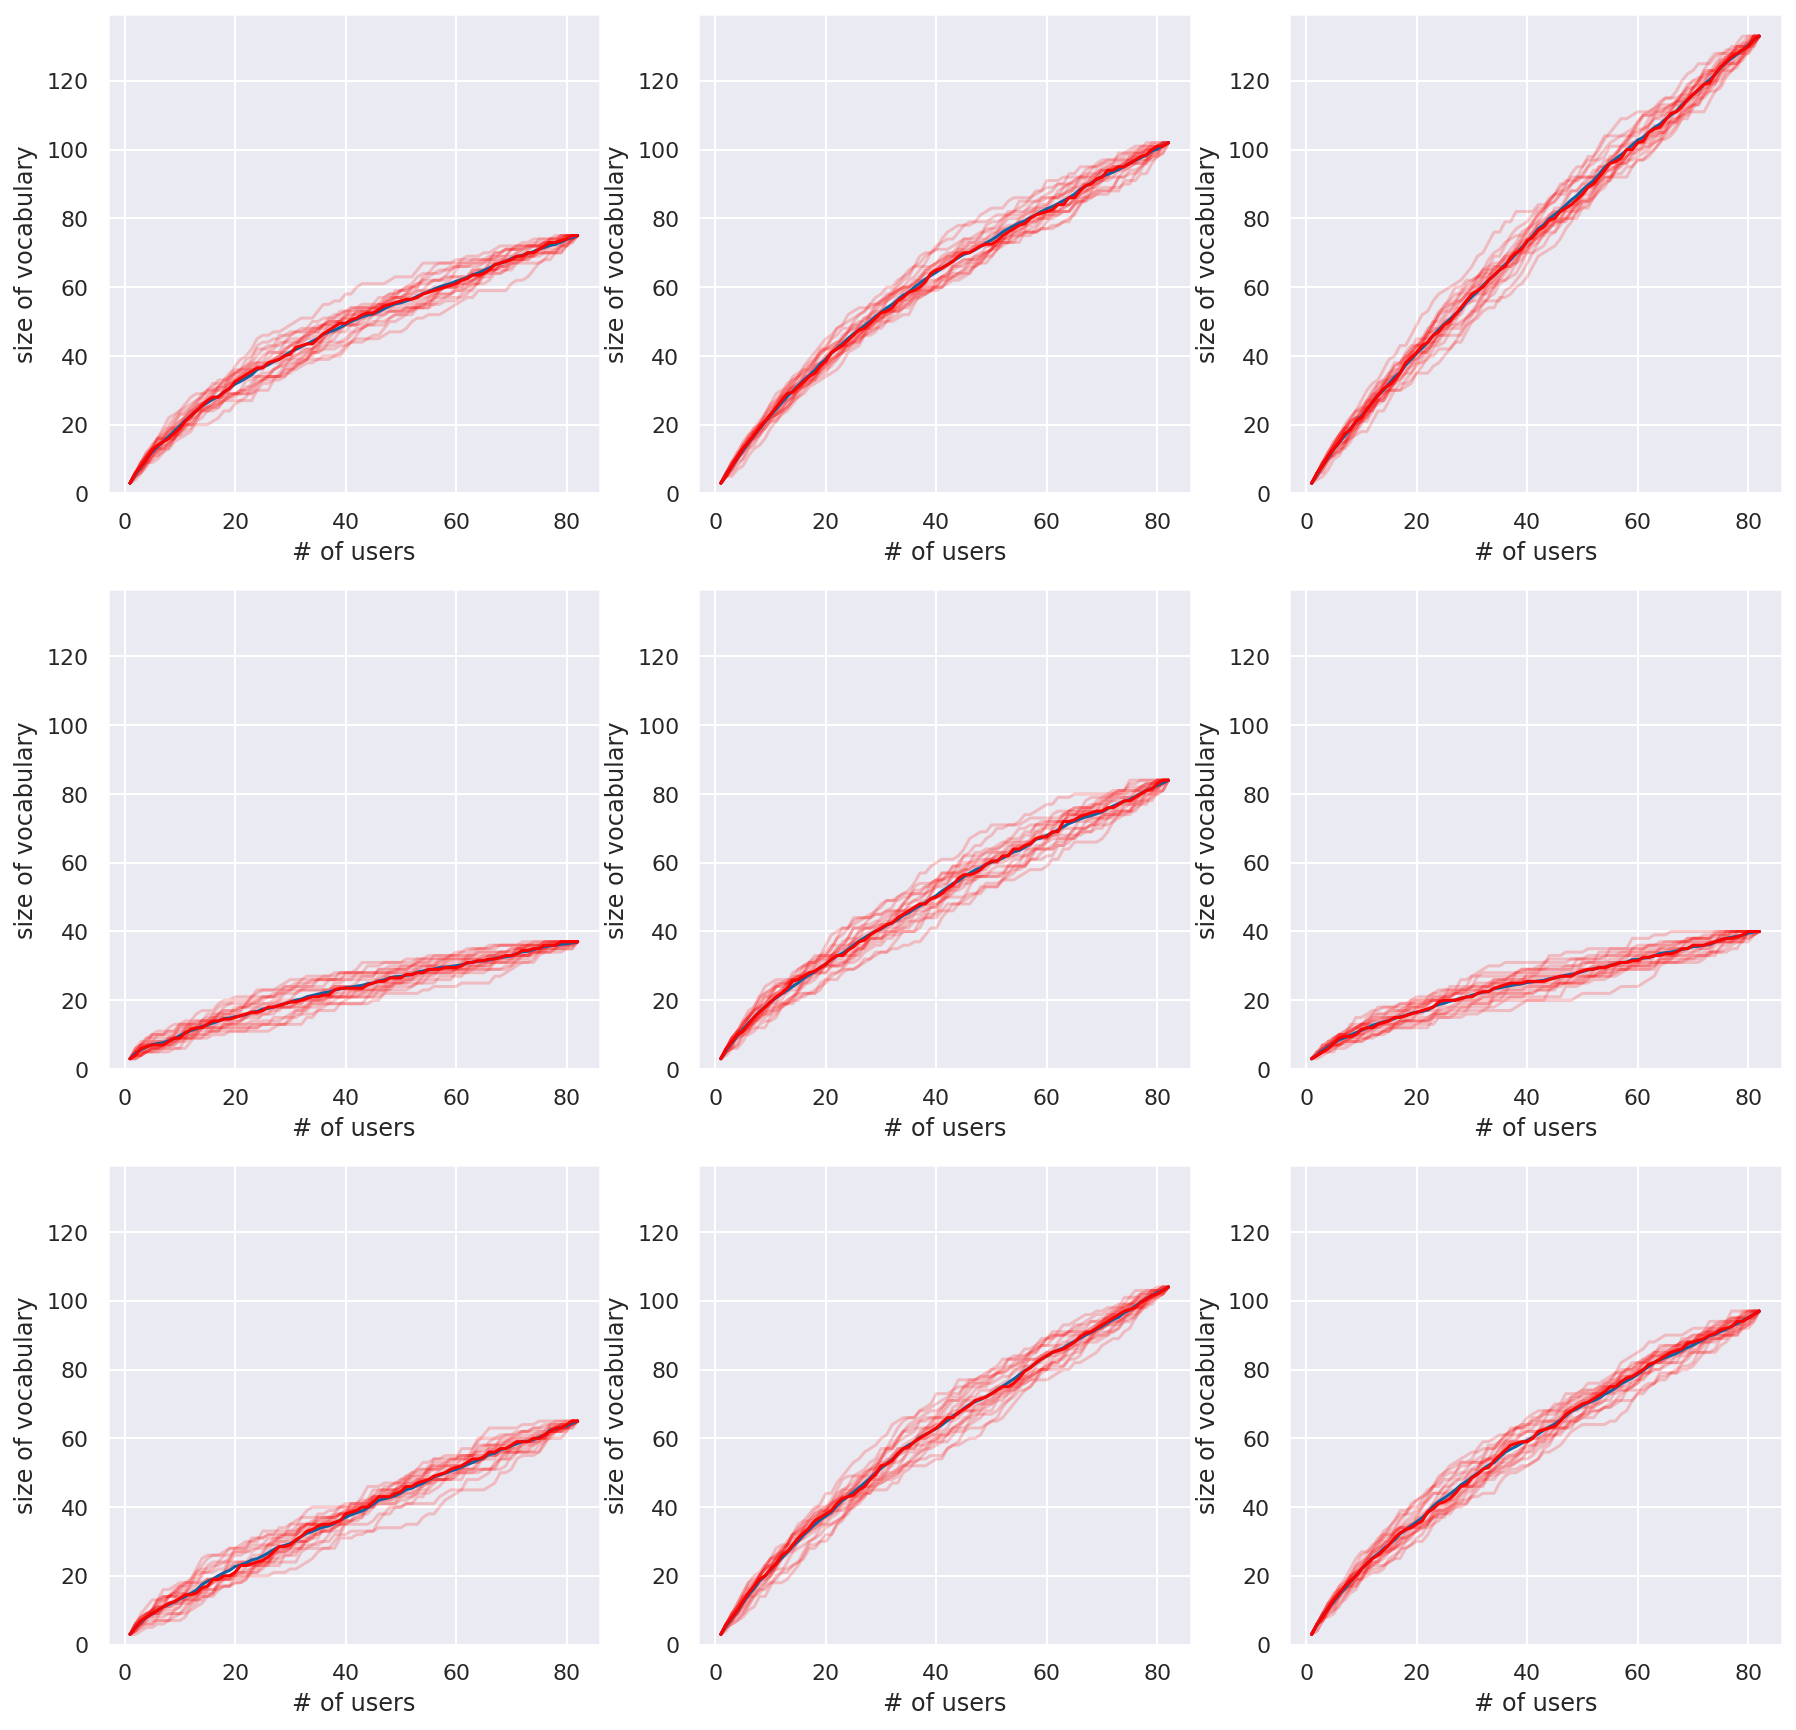

In [67]:
asymp_df = str2vocab(read_form("../data/raw/forms/Asymptotic_Emoji_Agreement_1.csv"))

asymp_df.drop(columns=['👕','🚓'],inplace=True)

plot_multi_trajectories(asymp_df)

## Completion Time Analysis

Median: 53 seconds
Mean: 68 seconds


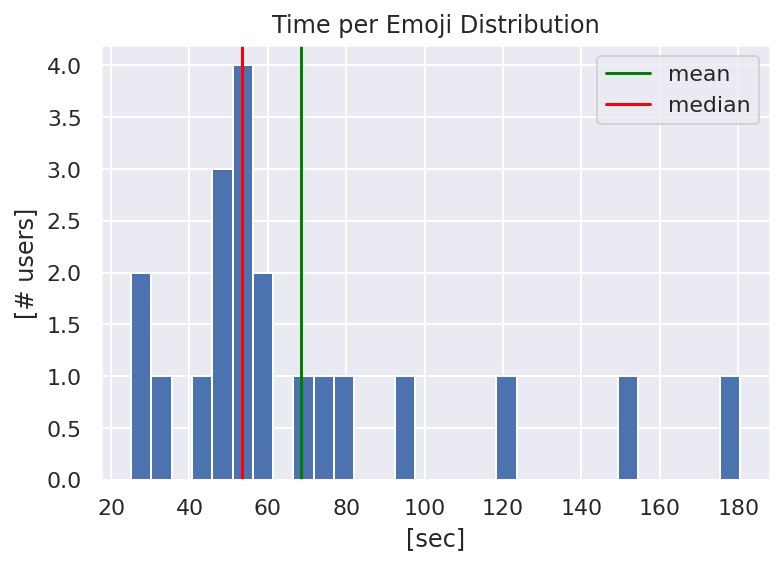

In [73]:
asymp_meta_df = read_meta("../data/raw/forms/emoji10/Emojis10_4META.csv",asymp_df.shape[1])

fig,ax = plt.subplots(1)
plot_emoji_time(asymp_meta_df,ax)